In [185]:
import pandas as pd
import pickle
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
# import data for training
df = pd.read_pickle('./Data/Cleandata/debug_training.pkl')

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

In [54]:
X = df[['borough', 'job_type', 'block', 'lot', 'zip_code', 'work_type', 'bldg_type',
        "owner's_business_type", 'non-profit', 'latitude', 'longitude',
        'council_district', 'issuance_year', 'issuance_month', 'issuance_day', 'job_start_year', 'job_start_month', 
        'job_start_day']]
y = df['permit_type']

In [55]:
warnings.filterwarnings('ignore')

le = LabelEncoder()
X['borough'] = le.fit_transform(X['borough'])
X['job_type'] = le.fit_transform(X['job_type'])
X["owner's_business_type"] = le.fit_transform(X["owner's_business_type"])
X['work_type'] = le.fit_transform(X['work_type'])
X['bldg_type'] = le.fit_transform(X['bldg_type'])
# X['block'] = le.fit_transform(X['block'])
# X['lot'] = le.fit_transform(X['lot'])
# X['zip_code'] = le.fit_transform(X['zip_code'])
X['non-profit'] = le.fit_transform(X['non-profit'])

In [56]:
#list for cols to scale
cols_to_scale = ['block','lot', 'zip_code', 'latitude', 'longitude', 'council_district', 'issuance_year',
                 'issuance_month', 'issuance_day', 'job_start_year', 'job_start_month', 'job_start_day']

#create and fit scaler
scaler = StandardScaler()

#scale selected data
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Deep Learning Model

## Model Definition

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [59]:
class RNN_Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Network, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return nn.functional.softmax(out, dim=1)

In [60]:
# Instantiate the model with output_size=5
model = RNN_Network(input_size=18, hidden_size=512, output_size=5)

In [61]:
# Cross-Entropy as loss function
criterion = nn.CrossEntropyLoss()

## Preparing Data For Training

In [62]:
# Assuming you have your data loaded and split as mentioned in your code
X_tensor = torch.tensor(X.values, dtype=torch.float32)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Assuming you have loaded and split your test set
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_encoded = label_encoder.transform(y_test)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Creating TensorDatasets
train_data = TensorDataset(X_tensor, y_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


## Model Training

In [63]:
from sklearn.metrics import accuracy_score, f1_score
def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total_instances = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        total_instances += len(y)

    return running_loss, total_instances

        
def train_loop(dataloader, model, criterion, optimizer, epochs=1, print_every=1):
    size = len(dataloader.dataset)

    for epoch in range(epochs):
        running_loss, total_instances = train_epoch(dataloader, model, criterion, optimizer)

        # Print running loss if print_every is specified
        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch + 1:>5d}/{epochs:>5d}] - Running Loss: {running_loss / total_instances:.6f}")

    print(f"Training completed\n-------------------------------")

    # Calculate F1 score and Accuracy on the training set
    train_predictions, train_labels = [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.unsqueeze(1)
            predictions = model(X_batch)
            _, predicted = torch.max(predictions, 1)
            train_predictions.extend(predicted.tolist())
            train_labels.extend(y_batch.tolist())

    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_f1 = f1_score(train_labels, train_predictions, average='weighted')

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Training F1 Score: {train_f1 * 100:.2f}%")

In [64]:
from sklearn.metrics import f1_score

def test_loop(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total_instances = 0  # New variable to keep track of total instances processed

    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(1)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total_instances += len(y)  # Increment total instances by the batch size

    test_loss /= num_batches
    correct /= total_instances  # Correct the calculation to divide by total instances
    accuracy = correct * 100

    # Calculate F1 score on the test set
    test_predictions, test_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.unsqueeze(1)
            predictions = model(X_batch)
            _, predicted = torch.max(predictions, 1)
            test_predictions.extend(predicted.tolist())
            test_labels.extend(y_batch.tolist())

    test_f1 = f1_score(test_labels, test_predictions, average='weighted')
    print(f"Test Error: \n Accuracy: {accuracy:.3f}%, Avg loss: {test_loss:.8f}, F1 Score: {test_f1:.4f} \n")

    return accuracy, test_f1

In [65]:
# Optimizer with Adam
model = RNN_Network(input_size=18, hidden_size=512, output_size=5)
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10 # Increase the number of Epochs as per the accuracy req.. Currently low for better runtime
print_every = 1
train_loop(train_loader, model, criterion, optimizer1, epochs, print_every)

Epoch [    1/   10] - Running Loss: 0.019052
Epoch [    2/   10] - Running Loss: 0.018739
Epoch [    3/   10] - Running Loss: 0.018746
Epoch [    4/   10] - Running Loss: 0.018729
Epoch [    5/   10] - Running Loss: 0.018744
Epoch [    6/   10] - Running Loss: 0.018745
Epoch [    7/   10] - Running Loss: 0.018744
Epoch [    8/   10] - Running Loss: 0.018744
Epoch [    9/   10] - Running Loss: 0.018743
Epoch [   10/   10] - Running Loss: 0.018728
Training completed
-------------------------------
Training Accuracy: 70.82%
Training F1 Score: 60.08%


In [66]:
# Optimizer with SGD
model = RNN_Network(input_size=18, hidden_size=512, output_size=5)
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 10 # Increase the number of Epochs as per the accuracy req.. Currently low for better runtime
print_every = 1
train_loop(train_loader, model, criterion, optimizer2, epochs, print_every)

Epoch [    1/   10] - Running Loss: 0.023058
Epoch [    2/   10] - Running Loss: 0.021547
Epoch [    3/   10] - Running Loss: 0.021242
Epoch [    4/   10] - Running Loss: 0.021073
Epoch [    5/   10] - Running Loss: 0.020837
Epoch [    6/   10] - Running Loss: 0.020542
Epoch [    7/   10] - Running Loss: 0.020309
Epoch [    8/   10] - Running Loss: 0.020167
Epoch [    9/   10] - Running Loss: 0.020023
Epoch [   10/   10] - Running Loss: 0.019938
Training completed
-------------------------------
Training Accuracy: 65.87%
Training F1 Score: 55.74%


## No Batch Normalization Applied

In [138]:
class RNN_Network_NBN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Network_NBN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        
        # Check the number of dimensions in the output tensor
        if len(out.shape) == 3:
            out = out[:, -1, :]  # Take the output from the last time step

        out = self.fc(out)
        return nn.functional.softmax(out, dim=1)

In [139]:
model_NBN = RNN_Network_NBN(input_size=18, hidden_size=512, output_size=5)

In [140]:
# Cross-Entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam as optimizer
optimizer = torch.optim.Adam(model_NBN.parameters(), lr=0.001)

### Batch Size, n=64

In [141]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [142]:
num_epochs = 10  # Number of training epochs. Adjust as needed.

for epoch in range(num_epochs):
    model_NBN.train()  # Set the model to training mode
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass: Compute predictions and loss
        outputs = model_NBN(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Batch [1/475], Loss: 1.5980
Epoch [1/10], Batch [101/475], Loss: 1.1872
Epoch [1/10], Batch [201/475], Loss: 1.2962
Epoch [1/10], Batch [301/475], Loss: 1.3581
Epoch [1/10], Batch [401/475], Loss: 1.3269
Epoch [1/10], Loss: 1.9043
Epoch [2/10], Batch [1/475], Loss: 1.1755
Epoch [2/10], Batch [101/475], Loss: 1.3114
Epoch [2/10], Batch [201/475], Loss: 1.4049
Epoch [2/10], Batch [301/475], Loss: 1.4361
Epoch [2/10], Batch [401/475], Loss: 1.3423
Epoch [2/10], Loss: 0.9254
Epoch [3/10], Batch [1/475], Loss: 1.3579
Epoch [3/10], Batch [101/475], Loss: 1.3892
Epoch [3/10], Batch [201/475], Loss: 1.4205
Epoch [3/10], Batch [301/475], Loss: 1.3580
Epoch [3/10], Batch [401/475], Loss: 1.2486
Epoch [3/10], Loss: 0.9294
Epoch [4/10], Batch [1/475], Loss: 1.4361
Epoch [4/10], Batch [101/475], Loss: 1.4205
Epoch [4/10], Batch [201/475], Loss: 1.2955
Epoch [4/10], Batch [301/475], Loss: 1.3267
Epoch [4/10], Batch [401/475], Loss: 1.2642
Epoch [4/10], Loss: 1.4048
Epoch [5/10], Batch 

In [143]:
model_NBN.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model_NBN(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100

print(f'Test Accuracy: {accuracy_percentage:.2f}%')


Test Accuracy: 71.44%


### Batch Size, n=256

In [145]:
batch_size = 256 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [146]:
num_epochs = 10  # Number of training epochs. Adjust as needed.

for epoch in range(num_epochs):
    model_NBN.train()  # Set the model to training mode
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass: Compute predictions and loss
        outputs = model_NBN(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Batch [1/119], Loss: 1.1978
Epoch [1/10], Batch [101/119], Loss: 1.1978
Epoch [1/10], Loss: 1.1587
Epoch [2/10], Batch [1/119], Loss: 1.1628
Epoch [2/10], Batch [101/119], Loss: 1.1784
Epoch [2/10], Loss: 1.1818
Epoch [3/10], Batch [1/119], Loss: 1.1783
Epoch [3/10], Batch [101/119], Loss: 1.2134
Epoch [3/10], Loss: 1.2125
Epoch [4/10], Batch [1/119], Loss: 1.1509
Epoch [4/10], Batch [101/119], Loss: 1.1471
Epoch [4/10], Loss: 1.1895
Epoch [5/10], Batch [1/119], Loss: 1.2371
Epoch [5/10], Batch [101/119], Loss: 1.1706
Epoch [5/10], Loss: 1.1664
Epoch [6/10], Batch [1/119], Loss: 1.2095
Epoch [6/10], Batch [101/119], Loss: 1.2056
Epoch [6/10], Loss: 1.1818
Epoch [7/10], Batch [1/119], Loss: 1.1705
Epoch [7/10], Batch [101/119], Loss: 1.2174
Epoch [7/10], Loss: 1.1433
Epoch [8/10], Batch [1/119], Loss: 1.1588
Epoch [8/10], Batch [101/119], Loss: 1.1939
Epoch [8/10], Loss: 1.1972
Epoch [9/10], Batch [1/119], Loss: 1.1939
Epoch [9/10], Batch [101/119], Loss: 1.2095
Epoch [9/1

In [147]:
model_NBN.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model_NBN(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100

print(f'Test Accuracy: {accuracy_percentage:.2f}%')


Test Accuracy: 71.46%


## Batch Normalization Applied

In [148]:
import torch.nn.functional as F

class RNN_Network_BN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Network_BN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        
        # Check if out is 3D or 2D
        if len(out.size()) == 3:
            # Reshape the output to (batch_size * sequence_length, hidden_size)
            batch_size, sequence_length, hidden_size = out.size()
            out = out.view(-1, hidden_size)
        else:
            # out is already 2D, no need to reshape
            batch_size, hidden_size = out.size()
            sequence_length = 1  # Set sequence_length to 1 for 2D case

        out = self.batch_norm(out)  # Apply batch normalization to RNN output
        
        # Reshape back to (batch_size, sequence_length, hidden_size) if it was 3D
        if len(out.size()) == 2:
            out = out.view(batch_size, sequence_length, hidden_size)
        
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return F.softmax(out, dim=1)



In [149]:
model_BN = RNN_Network_BN(input_size=18, hidden_size=512, output_size=5)

In [150]:
# Cross-Entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam as optimizer
optimizer = torch.optim.Adam(model_BN.parameters(), lr=0.001)

### Batch Size, n=64

In [151]:
batch_size = 64 

num_epochs = 10  # Number of training epochs. Adjust as needed.

for epoch in range(num_epochs):
    model_BN.train()  # Set the model to training mode
    for X_batch, y_batch in train_loader:
        # Forward pass: Compute predictions and loss
        outputs = model_BN(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.1596
Epoch [2/10], Loss: 1.1792
Epoch [3/10], Loss: 1.1891
Epoch [4/10], Loss: 1.0554
Epoch [5/10], Loss: 1.1214
Epoch [6/10], Loss: 1.1228
Epoch [7/10], Loss: 1.2067
Epoch [8/10], Loss: 1.1441
Epoch [9/10], Loss: 1.0900
Epoch [10/10], Loss: 1.1129


In [152]:
model_BN.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model_BN(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100

print(f'Test Accuracy: {accuracy_percentage:.2f}%')


Test Accuracy: 75.74%


### Batch Size, n=256

In [159]:
model_BN = RNN_Network_BN(input_size=18, hidden_size=512, output_size=5)

batch_size = 256 

num_epochs = 10  # Number of training epochs. Adjust as needed.

for epoch in range(num_epochs):
    model_BN.train()  # Set the model to training mode
    for X_batch, y_batch in train_loader:
        # Forward pass: Compute predictions and loss
        outputs = model_BN(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.5701
Epoch [2/10], Loss: 1.7455
Epoch [3/10], Loss: 1.4675
Epoch [4/10], Loss: 1.6130
Epoch [5/10], Loss: 1.6069
Epoch [6/10], Loss: 1.6770
Epoch [7/10], Loss: 1.6145
Epoch [8/10], Loss: 1.5891
Epoch [9/10], Loss: 1.6688
Epoch [10/10], Loss: 1.5966


In [160]:
model_BN.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model_BN(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100

print(f'Test Accuracy: {accuracy_percentage:.2f}%')


Test Accuracy: 17.58%


# Feature Importance Analysis
Procedures:
1. Randomly shuffle the values of each feature at a time on test data set.
2. Measure how much the performance drops.\

A significant drop indicates the feature is important.

In [164]:
def shuffle_feature(original_loader, feature_index):
    # Extracting tensors from the original DataLoader's dataset
    X, y = original_loader.dataset.tensors

    # Making a copy of the tensors
    X_shuffled = X.clone()

    # Shuffling the specified feature
    X_shuffled[:, feature_index] = X_shuffled[torch.randperm(X_shuffled.size(0)), feature_index]

    # Creating a new DataLoader with the shuffled data
    shuffled_loader = DataLoader(TensorDataset(X_shuffled, y), batch_size=batch_size)

    return shuffled_loader


In [181]:
def feature_importance(test_loader, model, criterion, X_train, batch_size):
    original_accuracy = test_loop(test_loader, model, criterion)
    importances = []
    
    #print(f"X_train.shape: {X_train.size()}")

    for i in range(X_train.shape[1]):
        shuffled_loader = shuffle_feature(test_loader, i)
        shuffled_accuracy = test_loop(shuffled_loader, model, criterion)

        importance = original_accuracy[0] - shuffled_accuracy[0]
        importances.append(importance)

    return importances


In [166]:
model = RNN_Network(input_size=18, hidden_size=512, output_size=5)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
# Need to update the train, test loader. Because shuffle is not invertible.
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, criterion, opt)
    test_loop(test_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
Epoch [    1/    1] - Running Loss: 0.019096
Training completed
-------------------------------
Training Accuracy: 70.80%
Training F1 Score: 60.06%
Test Error: 
 Accuracy: 71.424%, Avg loss: 1.19223612, F1 Score: 0.6089 

Epoch 2
-------------------------------
Epoch [    1/    1] - Running Loss: 0.018754
Training completed
-------------------------------
Training Accuracy: 70.82%
Training F1 Score: 60.08%
Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19073627, F1 Score: 0.6092 

Epoch 3
-------------------------------
Epoch [    1/    1] - Running Loss: 0.018730
Training completed
-------------------------------
Training Accuracy: 70.82%
Training F1 Score: 60.08%
Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19053065, F1 Score: 0.6092 

Epoch 4
-------------------------------
Epoch [    1/    1] - Running Loss: 0.018745
Training completed
-------------------------------
Training Accuracy: 70.82%
Training F1 Score: 60.08%
Test Error: 
 Accuracy: 71

In [183]:
importances = feature_importance(test_loader, model, criterion, X_train, batch_size)
print("Feature importances:", importances)

# Assuming X_train is a tensor with shape [n_samples, n_features]
# Extract feature names or indices from your dataset
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]  # Replace with actual feature names if available

# Pair feature names/indices with importances and sort them
feature_importance_pairs = list(zip(feature_names, importances))
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print the most important features
print("\nMost important features:")
for feature, importance in sorted_feature_importance_pairs:
    print(f"{feature}: {importance:.4f}")


Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043210, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19042883, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19060194, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043213, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.440%, Avg loss: 1.19057885, F1 Score: 0.6090 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043277, F1 Score: 0.6092 

Test Error: 
 Accuracy: 47.759%, Avg loss: 1.42729979, F1 Score: 0.3982 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043174, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043650, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19042879, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043026, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043333, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg loss: 1.19043133, F1 Score: 0.6092 

Test Error: 
 Accuracy: 71.457%, Avg l

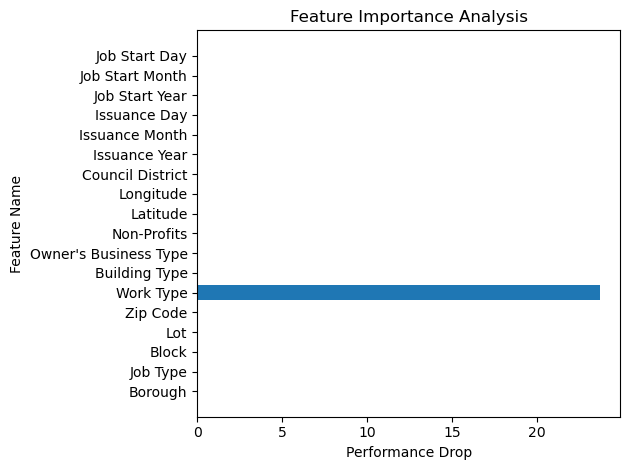

In [187]:
labels = ["Borough", "Job Type", "Block", "Lot", "Zip Code", "Work Type", "Building Type", "Owner's Business Type", "Non-Profits",
          "Latitude", "Longitude", "Council District", "Issuance Year", "Issuance Month", "Issuance Day", "Job Start Year", "Job Start Month", "Job Start Day"]
 
# Create a horizontal bar plot
plt.barh(range(len(importances)), importances)
 
# Set custom y-tick labels (since it's a horizontal bar plot)
plt.yticks(range(len(importances)), labels)
 
# Set the x-axis label (which represents the performance drop)
plt.xlabel("Performance Drop")
 
# Set the y-axis label (which represents the feature name)
plt.ylabel("Feature Name")
 
# Set the title of the plot
plt.title("Feature Importance Analysis")
 
# Show the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
# plt.show()
# plt.savefig("Feature Importance.png", dpi=100)